In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0047

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 773ms/step - loss: 0.0031
Average validation loss: 0.627694845199585
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 792ms/step - loss: 0.0031 - val_loss: 0.6277
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 782ms/step - loss: 0.0022 - val_loss: 0.6277
Average validation loss: 0.5813506245613098
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 798ms/step - loss: 0.0022 - val_loss: 0.6045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 828ms/step - loss: 0.0016 - val_loss: 0.6045
Average validation loss: 0.49255552887916565
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 839ms/step - loss: 0.0016 - val_loss: 0.5672
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 836ms/step - loss: 8.7323e-07
Average validation loss: 0.19206658005714417
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 847ms/step - loss: 8.7323e-07 - val_loss: 0.1921
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - loss: 8.8092e-07 - val_loss: 0.1921
Average validation loss: 0.1901346556842327
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 829ms/step - loss: 8.8092e-07 - val_loss: 0.1911
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 786ms/step - loss: 8.2721e-07 - val_loss: 0.1911
Average validation loss: 0.1588970124721527
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 798ms/step - loss: 8.2721e-07 - val_loss: 0.1804
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 885ms/step - loss: 3.9672e-07
Average validation loss: 0.037928940107425056
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 894ms/step - loss: 3.9672e-07 - val_loss: 0.0379
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 825ms/step - loss: 3.9077e-07 - val_loss: 0.0379
Average validation loss: 0.11694830035169919
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 837ms/step - loss: 3.9077e-07 - val_loss: 0.0774
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 884ms/step - loss: 3.7790e-07 - val_loss: 0.0774
Average validation loss: 0.07218819173673789
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 896ms/step - loss: 3.7790e-07 - val_loss: 0.0757
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 914ms/step - loss: 3.7238e-07 - val_loss: 0.0757
Average validation loss: 0.10523259018858273
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 927ms/step - loss: 3.7238e-07 - val_loss: 0.0831
Epoch 5/

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - loss: 2.3531e-07
Average validation loss: 0.0474242577329278
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 779ms/step - loss: 2.3531e-07 - val_loss: 0.0474
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 769ms/step - loss: 2.2249e-07 - val_loss: 0.0474
Average validation loss: 0.05095147341489792
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 780ms/step - loss: 2.2249e-07 - val_loss: 0.0492
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 773ms/step - loss: 2.1122e-07 - val_loss: 0.0492
Average validation loss: 0.05878751166164875
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step - loss: 2.1122e-07 - val_loss: 0.0524
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 767ms/step - loss: 2.0820e-07 - val_loss: 0.0524
Average validation loss: 0.03461783961392939
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 780ms/step - loss: 2.0820e-07 - val_loss: 0.0479
Saved mode

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 781ms/step - loss: 1.7844e-07
Average validation loss: 0.026399172935634853
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 791ms/step - loss: 1.7844e-07 - val_loss: 0.0264
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 784ms/step - loss: 1.8876e-07 - val_loss: 0.0264
Average validation loss: 0.024740791134536266
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 794ms/step - loss: 1.8876e-07 - val_loss: 0.0256
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 786ms/step - loss: 1.6794e-07 - val_loss: 0.0256
Average validation loss: 0.028092702850699425
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 796ms/step - loss: 1.6794e-07 - val_loss: 0.0264
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 781ms/step - loss: 1.54

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 792ms/step - loss: 3.1362e-07
Average validation loss: 0.020039013819769025
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 802ms/step - loss: 3.1362e-07 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 772ms/step - loss: 2.7841e-07 - val_loss: 0.0200
Average validation loss: 0.025745016212264698
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 782ms/step - loss: 2.7841e-07 - val_loss: 0.0229
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 777ms/step - loss: 2.5785e-07 - val_loss: 0.0229
Average validation loss: 0.01626270400205006
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 2.5785e-07 - val_loss: 0.0207
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 777ms/step - loss: 2.317

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 761ms/step - loss: 3.7680e-07
Average validation loss: 0.06412689872086048
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 771ms/step - loss: 3.7680e-07 - val_loss: 0.0641
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 778ms/step - loss: 3.1603e-07 - val_loss: 0.0641
Average validation loss: 0.05018259868957102
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 787ms/step - loss: 3.1603e-07 - val_loss: 0.0572
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 759ms/step - loss: 2.8831e-07 - val_loss: 0.0572
Average validation loss: 0.047957614203915
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 769ms/step - loss: 2.8831e-07 - val_loss: 0.0541
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weigh

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 771ms/step - loss: 1.4156e-07
Average validation loss: 0.01880956580862403
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 783ms/step - loss: 1.4156e-07 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 800ms/step - loss: 1.2837e-07 - val_loss: 0.0188
Average validation loss: 0.01922516160023709
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 812ms/step - loss: 1.2837e-07 - val_loss: 0.0190
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 834ms/step - loss: 1.1976e-07 - val_loss: 0.0190
Average validation loss: 0.017756595625542104
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 846ms/step - loss: 1.1976e-07 - val_loss: 0.0186
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 158s 844ms/step - loss: 1.2

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 784ms/step - loss: 1.5864e-07
Average validation loss: 0.020838302926027348
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 795ms/step - loss: 1.5864e-07 - val_loss: 0.0208
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 794ms/step - loss: 1.7017e-07 - val_loss: 0.0208
Average validation loss: 0.019985422857904007
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 806ms/step - loss: 1.7017e-07 - val_loss: 0.0204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 799ms/step - loss: 1.5278e-07 - val_loss: 0.0204
Average validation loss: 0.01874299709951239
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 810ms/step - loss: 1.5278e-07 - val_loss: 0.0199
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - loss: 1.0231e-07
Average validation loss: 0.017396242183167487
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 784ms/step - loss: 1.0231e-07 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 775ms/step - loss: 9.0030e-08 - val_loss: 0.0174
Average validation loss: 0.017567383794812486
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 786ms/step - loss: 9.0030e-08 - val_loss: 0.0175
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 780ms/step - loss: 8.0968e-08 - val_loss: 0.0175
Average validation loss: 0.018879106763051823
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 792ms/step - loss: 8.0968e-08 - val_loss: 0.0179
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 772ms/step - loss: 7.6441e-08 - val_loss: 0.0179
Average validation loss: 0.02538999996613711
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 783ms/step - loss: 7.6441e-08 - val_loss: 0.0198


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 775ms/step - loss: 8.9482e-08
Average validation loss: 0.01939786600673364
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 786ms/step - loss: 8.9482e-08 - val_loss: 0.0194
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 775ms/step - loss: 7.5351e-08 - val_loss: 0.0194
Average validation loss: 0.01977256113766796
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 786ms/step - loss: 7.5351e-08 - val_loss: 0.0196
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 776ms/step - loss: 6.5689e-08 - val_loss: 0.0196
Average validation loss: 0.017543998572768435
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 787ms/step - loss: 6.5689e-08 - val_loss: 0.0189
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 775ms/step - loss: 6

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 776ms/step - loss: 1.0833e-07
Average validation loss: 0.01986573722679168
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 787ms/step - loss: 1.0833e-07 - val_loss: 0.0199
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 9.3353e-08 - val_loss: 0.0199
Average validation loss: 0.018617243552580477
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 790ms/step - loss: 9.3353e-08 - val_loss: 0.0192
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 189s 780ms/step - loss: 8.0861e-08 - val_loss: 0.0192
Average validation loss: 0.02362839230336249
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 791ms/step - loss: 8.0861e-08 - val_loss: 0.0207
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 252s 781ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 777ms/step - loss: 1.8563e-07
Average validation loss: 0.02133890745850901
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 788ms/step - loss: 1.8563e-07 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 774ms/step - loss: 1.6481e-07 - val_loss: 0.0213
Average validation loss: 0.01713380733660112
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 785ms/step - loss: 1.6481e-07 - val_loss: 0.0192
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 766ms/step - loss: 1.4108e-07 - val_loss: 0.0192
Average validation loss: 0.031741221086122096
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 777ms/step - loss: 1.4108e-07 - val_loss: 0.0234
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 300s 773ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 778ms/step - loss: 2.1339e-07
Average validation loss: 0.018876149241502087
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 789ms/step - loss: 2.1339e-07 - val_loss: 0.0189
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 778ms/step - loss: 1.9230e-07 - val_loss: 0.0189
Average validation loss: 0.01721139094637086
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 789ms/step - loss: 1.9230e-07 - val_loss: 0.0180
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 775ms/step - loss: 1.5368e-07 - val_loss: 0.0180
Average validation loss: 0.023665421376548087
120/120 ━━━━━━━━━━━━━━━━━━━━ 284s 786ms/step - loss: 1.5368e-07 - val_loss: 0.0199
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 377s 776

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 772ms/step - loss: 2.2544e-07
Average validation loss: 0.019057090302036766
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 783ms/step - loss: 2.2544e-07 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 224s 774ms/step - loss: 2.0088e-07 - val_loss: 0.0191
Average validation loss: 0.022748562293499062
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 785ms/step - loss: 2.0088e-07 - val_loss: 0.0209
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 775ms/step - loss: 1.7756e-07 - val_loss: 0.0209
Average validation loss: 0.022208857195841522
144/144 ━━━━━━━━━━━━━━━━━━━━ 339s 786ms/step - loss: 1.7756e-07 - val_loss: 0.0213
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 451s 775ms/step - loss: 1.5601e-07 - val_loss: 0.0213
Average validation loss: 0.019829737936460232
144/144 ━━━━━━━━━━━━━━━━━━━━ 452s 786ms/step - loss: 1.5601e-07

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 782ms/step - loss: 6.2855e-08
Average validation loss: 0.017043784475390567
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 793ms/step - loss: 6.2855e-08 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 254s 792ms/step - loss: 5.3793e-08 - val_loss: 0.0170
Average validation loss: 0.015659805896575563
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 802ms/step - loss: 5.3793e-08 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 785ms/step - loss: 5.0319e-08 - val_loss: 0.0164
Average validation loss: 0.018352926561783535
160/160 ━━━━━━━━━━━━━━━━━━━━ 383s 796ms/step - loss: 5.0319e-08 - val_loss: 0.0170
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 511s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 774ms/step - loss: 8.9985e-08
Average validation loss: 0.017217849350709004
200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 784ms/step - loss: 8.9985e-08 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 775ms/step - loss: 7.1491e-08 - val_loss: 0.0172
Average validation loss: 0.01711190836474998
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 786ms/step - loss: 7.1491e-08 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 471s 782ms/step - loss: 6.5633e-08 - val_loss: 0.0172
Average validation loss: 0.015259101449046283
200/200 ━━━━━━━━━━━━━━━━━━━━ 473s 793ms/step - loss: 6.5633e-08 - val_loss: 0.0165
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 186s 774ms/step - loss: 1.2556e-07
Average validation loss: 0.024454985114425655
240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 785ms/step - loss: 1.2556e-07 - val_loss: 0.0245
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 374s 773ms/step - loss: 1.0135e-07 - val_loss: 0.0245
Average validation loss: 0.020127430888048064
240/240 ━━━━━━━━━━━━━━━━━━━━ 376s 783ms/step - loss: 1.0135e-07 - val_loss: 0.0223
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 562s 773ms/step - loss: 8.3789e-08 - val_loss: 0.0223
Average validation loss: 0.021418530595838092
240/240 ━━━━━━━━━━━━━━━━━━━━ 565s 784ms/step - loss: 8.3789e-08 - val_loss: 0.0220
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 751s 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.15610752016305923, 0.09109783356077969, 0.054127851336573565, 0.0400565448962152, 0.026475019583478573, 0.020266261253661166, 0.03006615739595145, 0.022464554330023624, 0.021986952467621973, 0.020066422407981007, 0.022610155039259956, 0.0224861797982594, 0.02310415622458095, 0.025959186659032032, 0.024907308470198283, 0.02038888843217501, 0.019651434492228146, 0.019992799317049503]
std_val_losses =  [0.13913095571629813, 0.06383280598043299, 0.024953089683205268, 0.01413311833116876, 0.00842230390226777, 0.005963075485685068, 0.012314938054406952, 0.004477998417239743, 0.0037922636226238307, 0.002110548142987347, 0.007839608068658977, 0.00468580895892019, 0.006551867840362243, 0.007126021455865116, 0.006210240435141583, 0.006000966300509386, 0.0035239897798037003, 0.0036977537454722206]


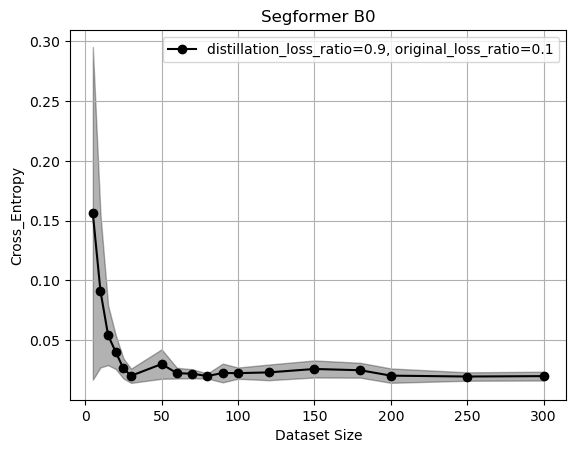

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()